<a href="https://colab.research.google.com/github/sohaillagha/Cats-vs-Dogs-Classifier-using-CNN/blob/main/Cats_vs_Dogs_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [6]:
!kaggle competitions download -c dogs-vs-cats

 97% 790M/812M [00:16<00:00, 32.5MB/s]
100% 812M/812M [00:16<00:00, 52.3MB/s]


In [7]:
import zipfile
zip_ref=zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()
import zipfile
zip_ref=zipfile.ZipFile('/content/test1.zip','r')
zip_ref.extractall('/content')
zip_ref.close()
import zipfile
zip_ref=zipfile.ZipFile('/content/train.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

import os
import shutil

# Path to the extracted training images
train_dir = '/content/train'

# Create 'cat' and 'dog' subdirectories if they don't exist
train_cat_dir = os.path.join(train_dir, 'cat')
train_dog_dir = os.path.join(train_dir, 'dog')

os.makedirs(train_cat_dir, exist_ok=True)
os.makedirs(train_dog_dir, exist_ok=True)

# Move images to respective subdirectories
# This loop might have already run, so it might not move files again if they are already moved
for filename in os.listdir(train_dir):
    if filename.startswith('cat.') and filename.endswith('.jpg'):
        # Check if the file is not already in the target directory before moving
        if not os.path.exists(os.path.join(train_cat_dir, filename)):
            shutil.move(os.path.join(train_dir, filename), os.path.join(train_cat_dir, filename))
    elif filename.startswith('dog.') and filename.endswith('.jpg'):
        # Check if the file is not already in the target directory before moving
        if not os.path.exists(os.path.join(train_dog_dir, filename)):
            shutil.move(os.path.join(train_dir, filename), os.path.join(train_dog_dir, filename))

# Now, create training and validation datasets by splitting the preprocessed train_dir
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256),
    validation_split=0.2, # Use 20% of the data for validation
    subset='training',
    seed=123 # Ensure reproducibility
)

validation_ds=keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256,256),
    validation_split=0.2, # Use 20% of the data for validation
    subset='validation',
    seed=123 # Ensure reproducibility
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [9]:
#normalize (numpyarray is 0-255,we want it 0-1)
def process(image,label):
  image=tf.cast(image/255. ,tf.float32)
  return image,label

train_ds=train_ds.map(process)
validation_ds=validation_ds.map(process)

In [10]:
#cnn model creaton
model=Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [13]:
history=model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 91ms/step - accuracy: 0.5781 - loss: 1.8201 - val_accuracy: 0.6000 - val_loss: 0.6445
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.7154 - loss: 0.5634 - val_accuracy: 0.6576 - val_loss: 0.6168
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 89ms/step - accuracy: 0.7636 - loss: 0.5002 - val_accuracy: 0.6914 - val_loss: 0.5654
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.8083 - loss: 0.4270 - val_accuracy: 0.7386 - val_loss: 0.5388
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - accuracy: 0.8420 - loss: 0.3630 - val_accuracy: 0.7390 - val_loss: 0.5592
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.8763 - loss: 0.2871 - val_accuracy: 0.5958 - val_loss: 1.9078
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.9081 - loss: 0.2239 - val_accuracy: 0.7748 - val_loss: 0.5686
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.9414 - loss: 0.1509 - 

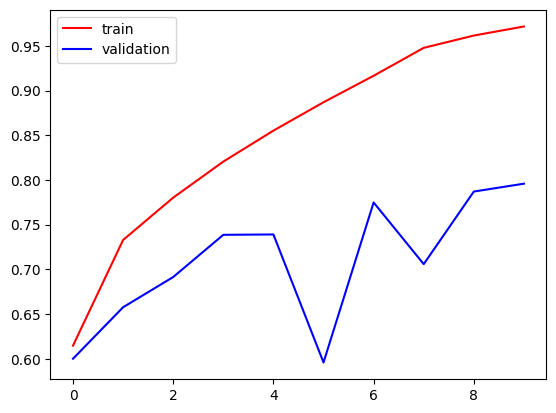

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

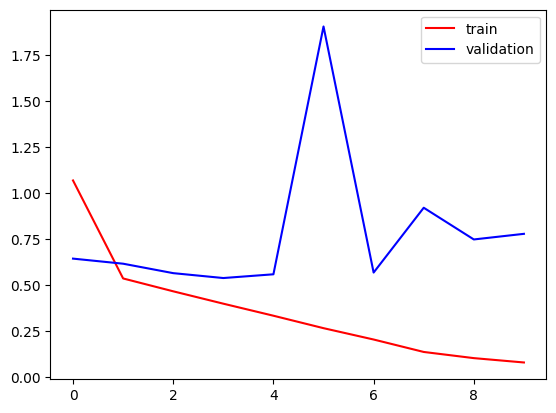

In [15]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [16]:
import cv2

In [97]:
test_imgc =cv2.imread('/content/A-Cat.jpg')


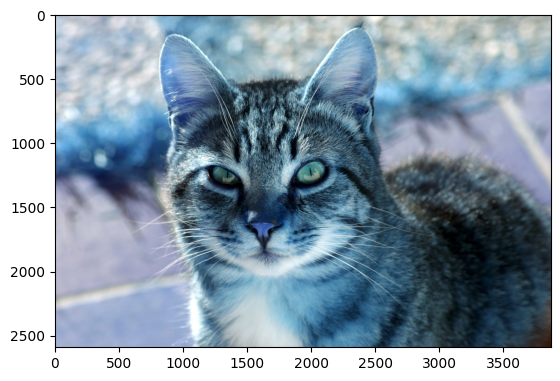

In [98]:
plt.imshow(test_imgc)

In [99]:
test_imgc.shape

(2592, 3872, 3)

In [100]:
test_imgc=cv2.resize(test_imgc,(256,256))

In [101]:
test_input=test_imgc.reshape((1,256,256,3))

In [102]:
import tensorflow as tf
# Normalize the test_input image by dividing by 255.0 and cast to float32
processed_test_input = tf.cast(test_input / 255.0, tf.float32)

# Use the processed_test_input for prediction
pred = model.predict(processed_test_input)

if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cat


In [103]:
test_imgd =cv2.imread('/content/Cute_dog.jpg')

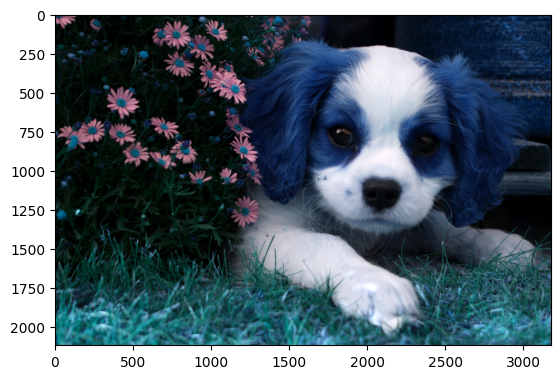

In [104]:

plt.imshow(test_imgd)

In [105]:

test_imgd.shape

(2117, 3176, 3)

In [108]:

test_imgd=cv2.resize(test_imgd,(256,256))

In [109]:

test_input1=test_imgd.reshape((1,256,256,3))

In [110]:
import tensorflow as tf

# Normalize the test_input image by dividing by 255.0 and cast to float32
processed_test_input1 = tf.cast(test_input1 / 255.0, tf.float32)

# Use the processed_test_input for prediction
pred = model.predict(processed_test_input1)

if pred[0] > 0.5:
    label = 'Dog'
else:
    label = 'Cat'
print(label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Dog
